In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,GRU,Input,LSTM,Masking
from sklearn.metrics import mean_squared_error
tf.random.set_seed(42)
n_rnn = 1
n_dense = 21
period_length = 3
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
def rho_w(T):#density of water kg/m3 at T deg C
    #10.1088/0026-1394/38/4/3
    a = [-3.983035,301.797,522528.9,69.34881,999.97495]
    return a[4]*(1-(T+a[0])**2*(T+a[1])/a[2]/(T+a[3]))
def latent(T):#latent heat of vaporization kJ/kg at T deg C
    return 2501 - 0002.361 * T

In [3]:
cook_flux = pd.read_csv('E:/usda/raw/CookIRCamET/Meteorological/Cook/EcTower/REddyProc/CookEast/6503_20240319_REP_output.csv',skiprows=[1,2],sep='\t').replace(to_replace=-9999,value=np.nan)

In [4]:
cook_hy2023_v1 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023V1_batch_output.csv')
cook_hy2023_v2 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023V2_batch_output.csv')
cook_hy2023 = pd.concat([cook_hy2023_v1,cook_hy2023_v2]).astype({'times':'datetime64'}).reset_index()

In [5]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Rg', 'Tair', 'rH', 'LE_uStar_f', 'LE_uStar_fqc']]
cook_flux['lambda']=cook_flux.Tair.apply(latent)
cook_flux['rho_w']=cook_flux.Tair.apply(rho_w)

In [6]:
cook_flux['ET']=cook_flux['LE_uStar_f']/cook_flux['lambda']/cook_flux['rho_w']*60*30#mm H20
cook_flux['Minutes']=60*(cook_flux['Hour']-np.floor(cook_flux['Hour']))

In [7]:
cook_flux['Hour']=np.floor(cook_flux['Hour'])

In [8]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Minutes', 'Rg', 'Tair', 'rH', 'ET']]

In [9]:
cook_flux['times']=pd.to_datetime(cook_flux['Year'].astype(str) + ' ' + cook_flux['DoY'].astype(str) + ' ' + cook_flux['Hour'].astype(int).astype(str)+':'+cook_flux['Minutes'].astype(int).astype(str),
    format='%Y %j %H:%M'
   )

In [10]:
cook_flux=cook_flux.groupby(['Year','DoY','Hour']).agg({'times':'max', 'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'ET':'sum'}).reset_index()

In [11]:
cook_hy2023['times'] = cook_hy2023.times.dt.tz_localize('UTC')

In [12]:
cook_flux['times'] = cook_flux.times.dt.tz_localize('Etc/GMT+8')

In [13]:
cook_flux['times'] = cook_flux.times.dt.tz_convert('UTC')

In [14]:
#should check tz's match

In [15]:
cook_flux.Tair+=273.15

<AxesSubplot:xlabel='times'>

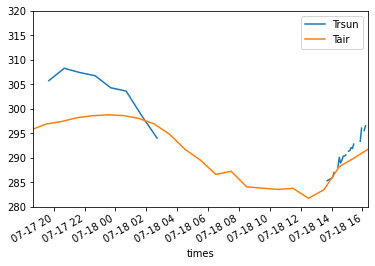

In [16]:
ax = cook_hy2023.plot(x='times',y='Trsun',
                 xlim = [cook_hy2023.times.values[-48],cook_hy2023.times.values[-1]],
                 ylim = [280,320])

cook_flux.plot(x='times',y='Tair',
                 xlim = [cook_hy2023.times.values[-48],cook_hy2023.times.values[-1]],
                 ylim = [280,320],ax=ax)

In [17]:
xlim=[pd.to_datetime('2023-06-15 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]

<AxesSubplot:xlabel='times'>

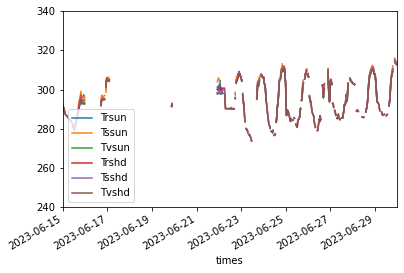

In [18]:
cook_hy2023.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[240,340])

<AxesSubplot:xlabel='times'>

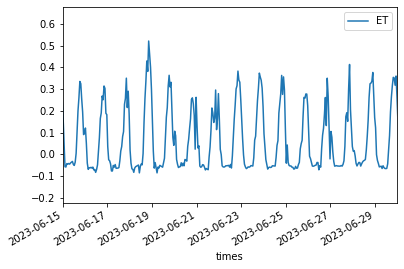

In [19]:
cook_flux.plot(x='times',y=['ET'],xlim=xlim)

In [20]:
cook_hy2023['times2']=cook_hy2023['times']
for i in cook_hy2023.index:
    mask = abs(cook_hy2023.loc[i,'times']-cook_flux['times'])==min(abs(cook_hy2023.loc[i,'times']-cook_flux['times']))
    cook_hy2023.loc[i,'times2'] = cook_flux.loc[mask,'times'].values[0]

In [21]:
cook_hy2023 = cook_hy2023.drop(columns=['times'])

In [22]:
cook_hy2023 = cook_hy2023.rename(columns={'times2':'times'}).drop(columns=['index', 'Unnamed: 0'])

In [23]:
cook_hy2023['times'] = cook_hy2023.astype({'times':'datetime64'}).reset_index().times.dt.tz_localize('UTC')

In [24]:
cook_flux = cook_flux.merge(cook_hy2023,how='left')
cook_flux=cook_flux[cook_flux.times>=cook_hy2023.times.min()]
cook_flux=cook_flux[cook_flux.times<=cook_hy2023.times.max()]

In [25]:
inputs = ['elevation', 'azimuth', 'fssun',
       'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd', 'Tssun',
       'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']
outputs = ['ET']

In [26]:
for i in inputs:
    if 'T' in i:
        cook_flux.loc[cook_flux[i]<250,i]=np.nan

In [27]:
bad_ir = cook_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [28]:
cook_flux['BadIR']=bad_ir

In [29]:
cook_flux['Hour']=cook_flux.times.dt.hour

In [30]:
cook_flux = cook_flux.groupby('times').aggregate('mean').reset_index()

In [31]:
cook_flux.to_csv('E:usda/work/CookIRCamET/Working/cook_hy2023_ec.csv',index=False)

In [32]:
cook_flux = pd.read_csv('E:usda/work/CookIRCamET/Working/cook_hy2023_ec.csv')

In [33]:
cook_flux_interp = cook_flux.copy().drop_duplicates().sort_values('times')

In [34]:
end_idx = cook_flux_interp[cook_flux_interp.times=='2023-03-22 03:30:00+00:00'].index[0]
start_idx = cook_flux_interp[cook_flux_interp.times=='2023-05-22 17:30:00+00:00'].index[0]
#make chunks around gap
cook_flux_chunk1 = cook_flux_interp.loc[0:end_idx+1,:]
cook_flux_chunk2 = cook_flux_interp.loc[start_idx:,:]

In [35]:
gb1 = cook_flux_chunk1.groupby(['Year','DoY'])

In [36]:
flux_days1 = [gb1.get_group(g).sort_values('times') for g in gb1.groups if len(gb1.get_group(g))==24]

In [37]:
gb2 = cook_flux_chunk2.groupby(['Year','DoY'])

In [38]:
flux_days2 = [gb2.get_group(g).sort_values('times') for g in gb2.groups if len(gb2.get_group(g))==24]

In [39]:
daily_flux = pd.concat([*flux_days1,*flux_days2])[['times','ET', 'Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']].reset_index().drop(columns='index')

In [40]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [41]:
n_feats = len(inputs)

In [42]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [43]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

In [44]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

In [45]:
daily_flux.to_csv('E:/usda/work/CookIRCamET/Working/cookhy2023_batches_processed.csv', index=False)

In [46]:
cprl_met_vars = ['NE_Year','NE_DOY','NE_Time in hhmm','NE_Rs in W/m^2','NE_air temp in degrees C','NE_RH in %']
cprl_lys_vars = ['Year','DOY','Tdec','ET (mm)']

cprl_met = pd.read_csv("E:/usda/raw/CookIRCamET/Meteorological/Cprl/NE_lys_2023_for_Joaquin/2023_NE_Cotton_Lys_ClimDat_New_15_min.csv")[cprl_met_vars]
cprl_lys = pd.read_csv("E:/usda/raw/CookIRCamET/Meteorological/Cprl/NE_lys_2023_for_Joaquin/2023_NE_Cotton_water_balance_15_min_matlab.csv")[cprl_lys_vars]

In [47]:
cprl_hy2023_v1 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cprlhy2023V1_batch_output.csv')
cprl_hy2023_v2 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cprlhy2023V2_batch_output.csv')
cprl_hy2023 = pd.concat([cprl_hy2023_v1,cprl_hy2023_v2]).astype({'times':'datetime64'}).reset_index()

In [48]:
cprl_hy2023['times'] = cprl_hy2023.times.dt.tz_localize('UTC')
cprl_hy2023 = cprl_hy2023[['times', 'daylight', 'elevation', 'azimuth',
       'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd',
       'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']]

In [49]:
cprl_met = cprl_met.rename(columns={'NE_Year':'Year','NE_DOY':'DoY','NE_Time in hhmm':'HHMM','NE_Rs in W/m^2':'Rg','NE_air temp in degrees C':'Tair','NE_RH in %':'rH'})

In [50]:
cprl_lys = cprl_lys.rename(columns={'DOY':'DoY','Tdec':'Hour','ET (mm)':'ET'})

In [51]:
cprl_lys['Minutes']=60*(cprl_lys['Hour']-np.floor(cprl_lys['Hour']))
cprl_lys['Minutes']=cprl_lys['Minutes'].astype(int).astype(str)
cprl_lys['Hour']=np.floor(cprl_lys['Hour']).astype(int).astype(str)

In [52]:
mask = cprl_lys.Hour=='24'
cprl_lys.loc[mask,'Hour']='0'
cprl_lys.loc[mask,'DoY']=cprl_lys.loc[mask,'DoY']+1

In [53]:
mask = cprl_lys.DoY==366
cprl_lys.loc[mask,'DoY']=1
cprl_lys.loc[mask,'Year']=2024

In [54]:
cprl_met['Hour'] = np.floor(cprl_met.HHMM/100).astype(int).astype(str)
cprl_met['Minutes'] = 100*(cprl_met.HHMM/100 - np.floor(cprl_met.HHMM/100))
cprl_met['Minutes'] = cprl_met.Minutes.astype(int).astype(str)
cprl_met['Minutes']=cprl_met.Minutes.replace({'14':'15','44':'45'})

In [55]:
mask = cprl_met.Hour=='24'
cprl_met.loc[mask,'Hour']='0'
cprl_met.loc[mask,'DoY']=cprl_met.loc[mask,'DoY']+1

In [56]:
mask = cprl_met.DoY==366
cprl_met.loc[mask,'DoY']=1
cprl_met.loc[mask,'Year']=2024

In [57]:
cprl_met_lys=cprl_lys.merge(cprl_met,on=['Hour','Minutes','Year','DoY'],how='left')

In [58]:
cprl_met_lys=cprl_met_lys.groupby(['Year','DoY','Hour']).agg({'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'ET':'sum'}).reset_index(drop=False)

In [59]:
cprl_met_lys['times']=pd.to_datetime(cprl_met_lys['Year'].astype(str) + ' ' + cprl_met_lys['DoY'].astype(str) + ' ' + cprl_met_lys['Hour']+':'+'00',
    format='%Y %j %H:%M'
   )

In [60]:
cprl_met_lys.Tair+=273.15

In [61]:
cprl_met_lys

,Year,DoY,Hour,Rg,Tair,rH,ET,times
0,2023,1,0,NaN,NaN,NaN,0.027360,2023-01-01 00:00:00
1,2023,1,1,NaN,NaN,NaN,-0.175040,2023-01-01 01:00:00
2,2023,1,10,NaN,NaN,NaN,0.012802,2023-01-01 10:00:00
3,2023,1,11,NaN,NaN,NaN,-0.029630,2023-01-01 11:00:00
4,2023,1,12,NaN,NaN,NaN,0.089060,2023-01-01 12:00:00
...,...,...,...,...,...,...,...,...
8756,2023,365,6,NaN,NaN,NaN,0.000000,2023-12-31 06:00:00
8757,2023,365,7,NaN,NaN,NaN,0.000000,2023-12-31 07:00:00
8758,2023,365,8,NaN,NaN,NaN,0.000000,2023-12-31 08:00:00
8759,2023,365,9,NaN,NaN,NaN,0.000000,2023-12-31 09:00:00


In [62]:
cprl_met_lys['times'] = cprl_met_lys.times.dt.tz_localize('Etc/GMT+6')

In [63]:
cprl_met_lys['times'] = cprl_met_lys.times.dt.tz_convert('UTC')

In [64]:
cprl_hy2023['times2']=cprl_hy2023['times']
for i in cprl_hy2023.index:
    mask = abs(cprl_hy2023.loc[i,'times']-cprl_met_lys['times'])==min(abs(cprl_hy2023.loc[i,'times']-cprl_met_lys['times']))
    cprl_hy2023.loc[i,'times2'] = cprl_met_lys.loc[mask,'times'].values[0]

In [65]:
cprl_hy2023 = cprl_hy2023.drop(columns=['times']).rename(columns={'times2':'times'})

In [66]:
cprl_hy2023 = cprl_hy2023.astype({'times':'datetime64'}).reset_index(drop=True)

In [67]:
cprl_hy2023['times'] = cprl_hy2023.times.dt.tz_localize('UTC')

In [68]:
cprl_hy2023 = cprl_hy2023.groupby(['times']).agg({'daylight':'mean', 'elevation':'mean', 'azimuth':'mean',
       'fssun':'mean', 'fsshd':'mean', 'frsun':'mean', 'frshd':'mean', 'fvsun':'mean', 'fvshd':'mean', 'fwsun':'mean', 'fwshd':'mean',
       'Tssun':'mean', 'Tsshd':'mean', 'Trsun':'mean', 'Trshd':'mean', 'Tvsun':'mean', 'Tvshd':'mean', 'Twsun':'mean', 'Twshd':'mean'}).reset_index(drop=False) 

In [69]:
cprl_flux = cprl_met_lys.merge(cprl_hy2023,how='left',on = 'times')

In [70]:
cprl_flux

,Year,DoY,Hour,Rg,Tair,rH,ET,times,daylight,elevation,...,fwsun,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd
0,2023,1,0,NaN,NaN,NaN,0.027360,2023-01-01 06:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,1,1,NaN,NaN,NaN,-0.175040,2023-01-01 07:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,1,10,NaN,NaN,NaN,0.012802,2023-01-01 16:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,1,11,NaN,NaN,NaN,-0.029630,2023-01-01 17:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,1,12,NaN,NaN,NaN,0.089060,2023-01-01 18:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2023,365,6,NaN,NaN,NaN,0.000000,2023-12-31 12:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,2023,365,7,NaN,NaN,NaN,0.000000,2023-12-31 13:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,2023,365,8,NaN,NaN,NaN,0.000000,2023-12-31 14:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8759,2023,365,9,NaN,NaN,NaN,0.000000,2023-12-31 15:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='times'>

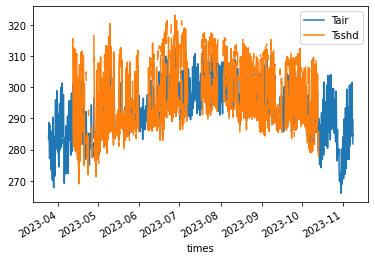

In [71]:
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y='Tsshd',ax=ax)

In [72]:
#timezone check & "good chunks"
xlim_list = []

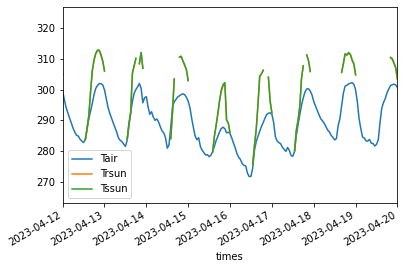

In [73]:
xlim=[pd.to_datetime('2023-04-12 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-04-20 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

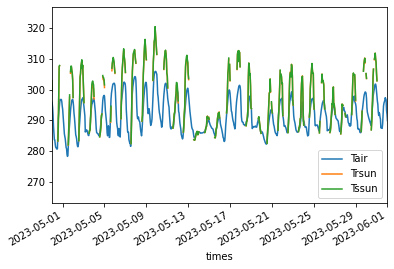

In [74]:
xlim=[pd.to_datetime('2023-04-30 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-01 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_met_lys.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

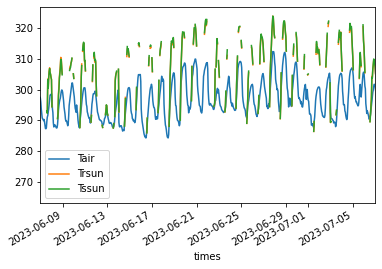

In [75]:
xlim=[pd.to_datetime('2023-06-07 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-07 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

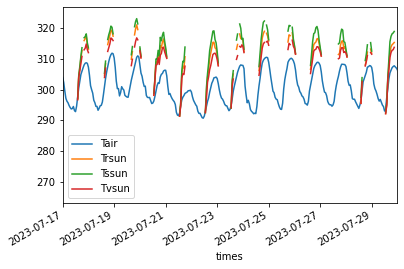

In [76]:
xlim=[pd.to_datetime('2023-07-17 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

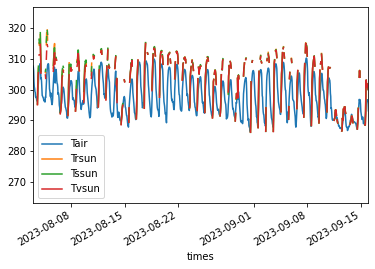

In [77]:
xlim=[pd.to_datetime('2023-08-03 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-09-16 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

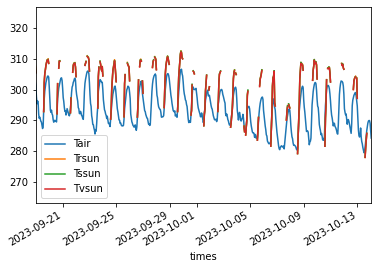

In [78]:
xlim=[pd.to_datetime('2023-09-19 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-10-14 00:00:00',format='%Y-%m-%d %H:%M:%S')]
ax = cprl_flux.plot(x='times',y='Tair')
cprl_flux.plot(x='times',y=['Trsun','Tssun','Tvsun'],xlim=xlim,ax=ax)
xlim_list.append(xlim)

In [79]:
for i in inputs:
    if 'T' in i:
        cprl_flux.loc[cprl_flux[i]<250,i]=np.nan

In [80]:
bad_ir = cprl_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [81]:
cprl_flux['BadIR']=bad_ir

In [82]:
cprl_flux

,Year,DoY,Hour,Rg,Tair,rH,ET,times,daylight,elevation,...,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd,BadIR
0,2023,1,0,NaN,NaN,NaN,0.027360,2023-01-01 06:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,2023,1,1,NaN,NaN,NaN,-0.175040,2023-01-01 07:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,2023,1,10,NaN,NaN,NaN,0.012802,2023-01-01 16:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,2023,1,11,NaN,NaN,NaN,-0.029630,2023-01-01 17:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,2023,1,12,NaN,NaN,NaN,0.089060,2023-01-01 18:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2023,365,6,NaN,NaN,NaN,0.000000,2023-12-31 12:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8757,2023,365,7,NaN,NaN,NaN,0.000000,2023-12-31 13:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8758,2023,365,8,NaN,NaN,NaN,0.000000,2023-12-31 14:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8759,2023,365,9,NaN,NaN,NaN,0.000000,2023-12-31 15:00:00+00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [83]:
cprl_flux = cprl_flux.sort_values('times').reset_index(drop=True)

In [84]:
cprl_flux.to_csv('test.csv',index=False)

In [85]:
chunks = []
gbs = []
fds = []

In [86]:
for xlim in xlim_list:
    print(xlim)
    start_idx = cprl_flux[cprl_flux.times==xlim[0].tz_localize('UTC')].index[0]
    end_idx = cprl_flux[cprl_flux.times==xlim[1].tz_localize('UTC')].index[0]
    print(start_idx,end_idx)
    #make chunks
    cprl_flux_chunks=cprl_flux.loc[start_idx:end_idx+1,:]
    chunks.append(cprl_flux_chunks)
    gb=cprl_flux_chunks.groupby(['Year','DoY'])
    gbs.append(gb)
    fds.append([gb.get_group(g).sort_values('times') for g in gb.groups if len(gb.get_group(g))==24])

[Timestamp('2023-04-12 00:00:00'), Timestamp('2023-04-20 00:00:00')]
2418 2610
[Timestamp('2023-04-30 00:00:00'), Timestamp('2023-06-01 00:00:00')]
2850 3618
[Timestamp('2023-06-07 00:00:00'), Timestamp('2023-07-07 00:00:00')]
3762 4482
[Timestamp('2023-07-17 00:00:00'), Timestamp('2023-07-30 00:00:00')]
4722 5034
[Timestamp('2023-08-03 00:00:00'), Timestamp('2023-09-16 00:00:00')]
5130 6186
[Timestamp('2023-09-19 00:00:00'), Timestamp('2023-10-14 00:00:00')]
6258 6858


In [87]:
fds = [f
       for fd in fds
       for f in fd ]

In [88]:
daily_flux = pd.concat(fds).reset_index(drop=True)

In [89]:
daily_flux = daily_flux[['times','ET', 'Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']]

In [90]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [91]:
n_feats = len(inputs)

In [92]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [93]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

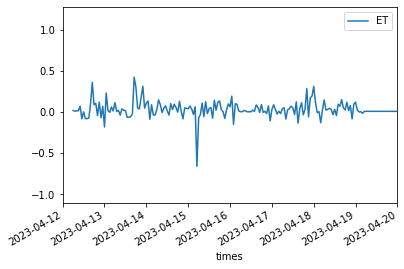

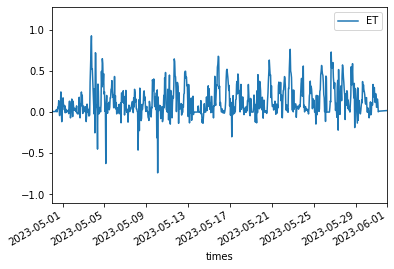

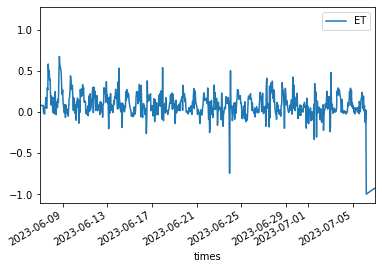

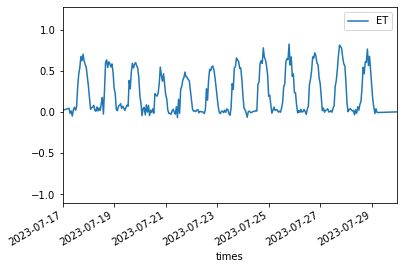

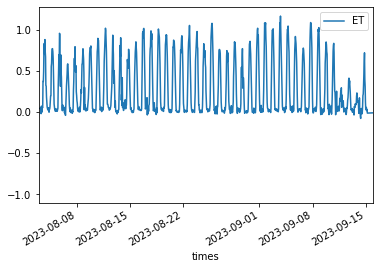

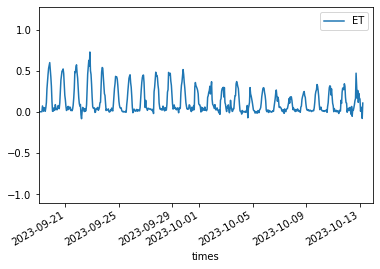

In [94]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='ET',xlim=xlim)

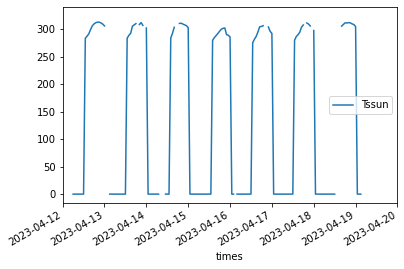

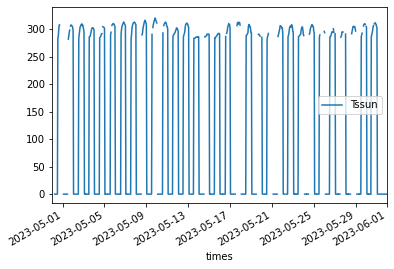

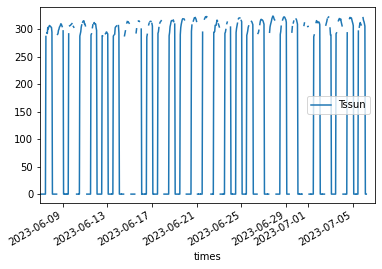

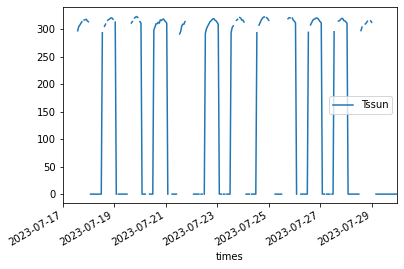

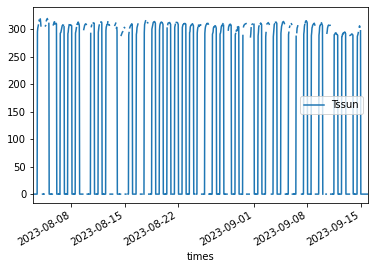

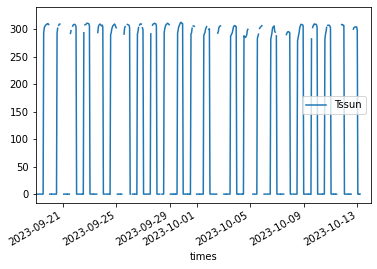

In [95]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [96]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

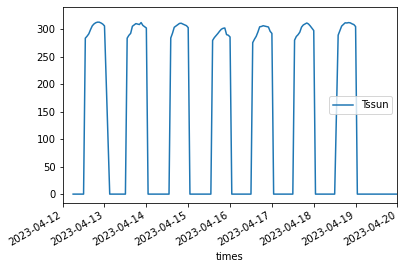

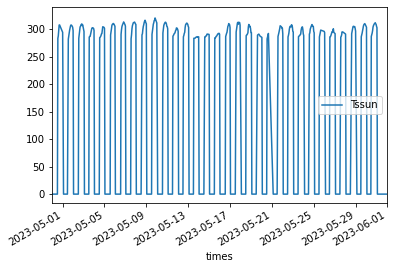

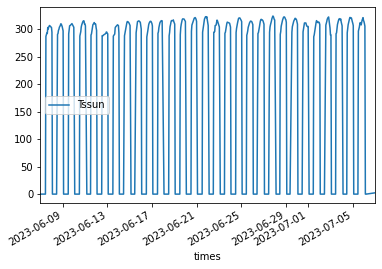

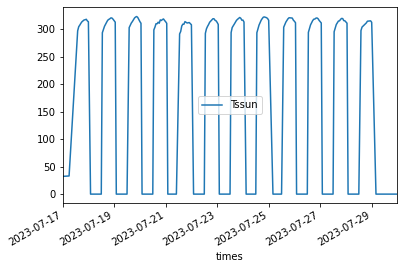

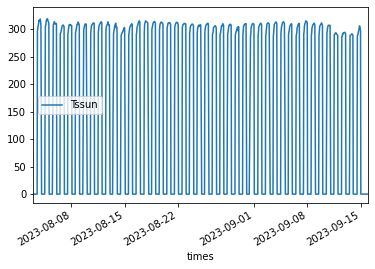

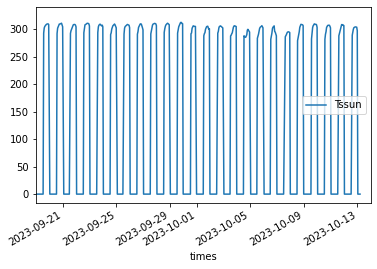

In [97]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [98]:
daily_flux.to_csv('E:/usda/work/CookIRCamET/Working/cprlhy2023_batches_processed.csv', index=False)